In [592]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [818]:
ir = pd.read_excel('офз.xlsx', index_col=0, header=1) / 100 /254

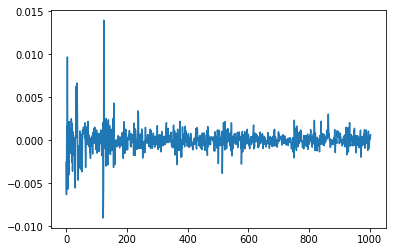

In [819]:
plt.plot(components[:,2]);

In [820]:
dates = np.array(['-'.join(x.split('.')[::-1]) for x in ir.index]).astype('M8[D]')
ir.index = dates
ir.sort_index(inplace=True)
dates = dates[::-1][1:]

In [821]:
ir_diff = ir.diff().dropna()# берем разности

In [822]:
pca = PCA(n_components=3)
components = pca.fit_transform(ir_diff)

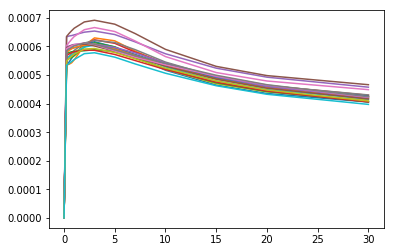

In [823]:
for i in range(20):
    plt.plot(np.concatenate((np.zeros(1), ir.columns)), np.concatenate((np.zeros(1), ir.iloc[i].values)))

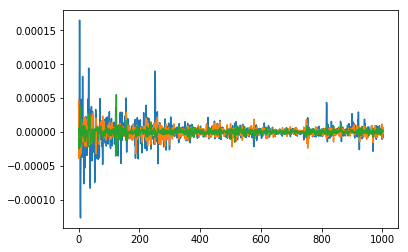

In [824]:
for i in range(3):
    plt.plot(components[:,i])

__Vasicek Model:__ $dr_t = \alpha(b-r_t)dt + \sigma dW_t$   
Точное решение: $r_t \sim N\left(r_0 e^{-\alpha t} + b (1-e^{-\alpha t}),\,\tfrac{\sigma^2}{2\alpha}\left(1-e^{-2\alpha t}\right)\right)
$

explain_var for 3 comp 0.954 %


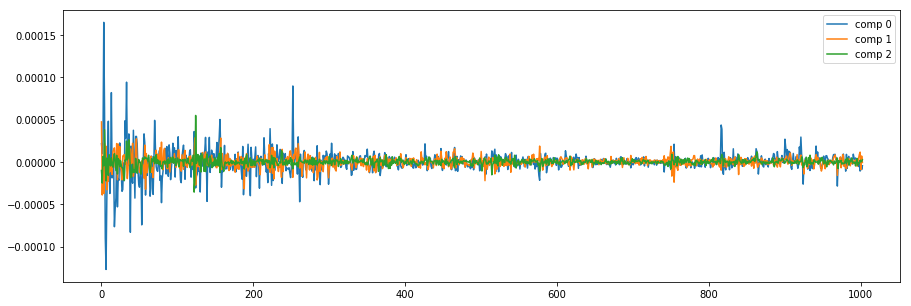

In [825]:
print(f"explain_var for 3 comp {pca.explained_variance_ratio_[:3].sum():.3f} %")
plt.figure(figsize=(15,5))
for i in range(3):
    plt.plot(components[:,i], label=f"comp {i}")
plt.legend();

In [826]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [827]:
#tsplot(components[dates[:]>np.datetime64('2016-12-10'),2])

In [828]:
# import statsmodels.tsa.stattools as ts

# result = ts.adfuller(components[dates[:]>np.datetime64('2016-12-10'),1]) # maxlag is now set to 1
# result

In [829]:
def ClosestTradeDate(day, dates = dates):
    return dates[dates <= day][-1]

last traid date before forecase 2018-11-30
forecast date 2018-12-03


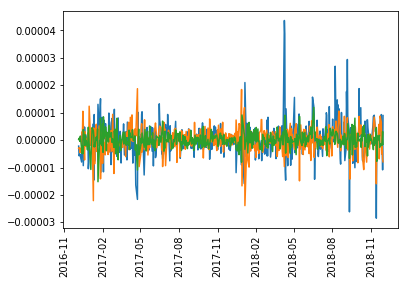

In [830]:
forecastDate = np.datetime64('2018-12-03')
tradeDate1 = ClosestTradeDate(forecastDate-1)
tradeDate10 = ClosestTradeDate(forecastDate-10)
startDate = np.datetime64('2016-12-03')

print('last traid date before forecase', tradeDate1)
print('forecast date', forecastDate)

#logr = np.log(first_comp[dates < forDate] - min(first_comp[dates < forDate]) + 0.002)
components_for = components[(dates <= tradeDate1) & (dates >= startDate)]

r0_diff = components_for[-1] # разница ставок в момент tradeDate1 для каждой из компоненты
r0 = ir.loc[tradeDate1] # реальная кривая в момент времени tradeDate1

plt.plot(dates[(dates <= tradeDate1) & (dates >= startDate)], components_for[:,0])
plt.plot(dates[(dates <= tradeDate1) & (dates >= startDate)], components_for[:,1])
plt.plot(dates[(dates <= tradeDate1) & (dates >= startDate)], components_for[:,2])

plt.xticks(rotation=90);

In [831]:
def minimizeNLogLikelihood(r, dates, lastDate):
    dt = 1 
    rt = r    
    N = r.shape[0]
    params0 = np.array([0.0000001,0.0000001,0.0000001])
    
    def VasicekLogLikelihood(params):
        alpha, b, sigma = params[0], params[1], params[2] 
        return -(N-1)*np.log(alpha/(sigma**2*(1-np.exp(-2*alpha*dt)))) \
            - alpha/(sigma**2*(1-np.exp(-2*alpha*dt)))*np.sum(-(rt[:-1] - rt[1:]*np.exp(-alpha*dt)-b*(1-np.exp(-alpha*dt)))**2) 
    
    params_opt = minimize(VasicekLogLikelihood, params0, method='Powell')
    return params_opt.x

In [832]:
params = np.zeros((3,3))

for i in range(3):
    params[i] = minimizeNLogLikelihood(components[:,i], dates, forDate)
params

array([[ 1.55745625e+00,  2.32119560e-08,  1.86639400e-05],
       [ 4.46745009e+00, -8.14321870e-08,  1.53162504e-05],
       [ 4.40655619e+00, -2.71215467e-09,  1.00568723e-05]])

In [833]:
bond_count = 2
bond_info = {}

for bond_i in range(bond_count): 
    coupons_i = pd.read_excel('офз_график_выплат.xlsx', sheet_name=bond_i)[['Date', 'Coupon']].astype({'Date':'M8[D]'})   

    info = pd.read_excel('офз_описание.xlsx', bond_i, index_col=0)
    num_coupons = info.loc['Периодичность выплаты купона в год'].values[0]
    face = info.loc['Номинальная стоимость'].values[0]
    expDate = np.datetime64(info.loc['Дата погашения'].values[0])

    coupons_rate = coupons_i['Coupon'].values / num_coupons / 100
    coupons_date = coupons_i['Date'].values 
#     coupons_rate = coupons_rate[coupons_date > tradeDate1]  
#     coupons_date = coupons_date[coupons_date > tradeDate1].reshape(-1,1)
    
    bond_info[bond_i] = {
        'coupons_date': coupons_date,
        'coupons_rate': coupons_rate,
        'expDate': expDate,
        'face': face
    }
for i in bond_info:
    print(i)
    print(bond_info[i]['coupons_rate'].mean())
    print(bond_info[i]['expDate'])
    print()

0
0.038000000000000006
2021-04-14T00:00:00.000000

1
0.040750000000000015
2027-02-03T00:00:00.000000



In [834]:
# генерируем приращения после pca для момента forDate 
def VasicekPath(params,r0, N):
    dt = 1    
    alpha, b, sigma = params[0], params[1], params[2]
    r = [] # варианты аля-ставки на один из аля-TtM  
    for j in range(N):
        r1 = r0 + alpha*(b-r0)*dt + sigma*np.sqrt(dt)*np.random.randn()
        r.append(r1)
    return r

In [835]:
#Для каждой из облигации симулируем N 'ставок' по каждой из компоненты для момента for Date
#на выходе для каждой из облигации у нас будет матрица размером N*n_comp

N = 100
for bond_i in range(bond_count):
    print('bond', bond_i)
    r = []    
    for j in range(params.shape[0]):        
        r.append(VasicekPath(params[j], r0_diff[j], N))
    bond_info[bond_i]['simulations'] = np.array(r).T

bond 0
bond 1


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text xticklabel objects>)

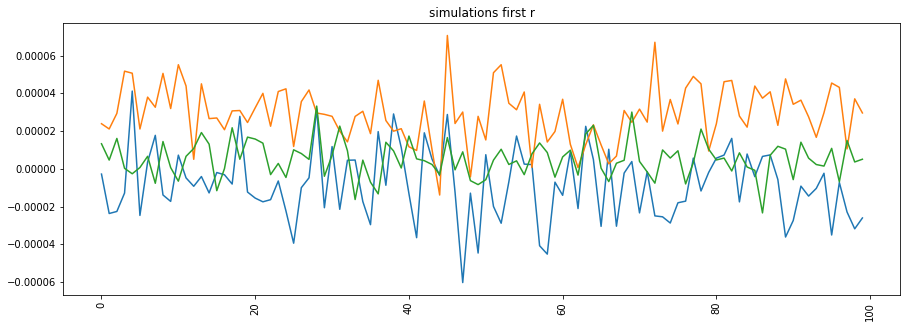

In [836]:
#пример симуляции N ставок для каждой из компоненты

bond_i = 0 # далее будем смотреть на конкретную облигацию
bond_result = bond_info[bond_i]

dates_index = pd.date_range(forecastDate, bond_result['expDate'])[:-1]

plt.figure(figsize =(15,5))
plt.subplot(111)
plt.plot(bond_result['simulations'][:, :])
plt.title('simulations first r')
plt.xticks(rotation=90)

In [837]:
#переводим аля-ставки в разности реальных ставок 
inverse_r = pca.inverse_transform(bond_result['simulations'])

#переводим разности в кривую YTM. 
inverse_r = r0.values + np.cumsum(inverse_r,0)

In [838]:
r0.index

Float64Index([0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0, 20.0,
              30.0],
             dtype='float64')

In [839]:
#используем линейную интерполяцию (дневную)
from scipy.interpolate import interp1d

x = [0]+list(r0.index*360)
xnew = np.arange(1, 30*360, 1)

inverse_r_interpolate = np.zeros((inverse_r.shape[0], len(xnew)))

for i, ofz in enumerate(inverse_r):
    y = [0]+list(ofz)
    
    f = interp1d(x, y)
    ynew = f(xnew)
    
    inverse_r_interpolate[i] = ynew

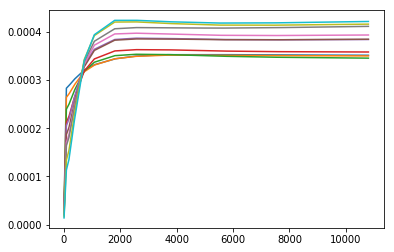

In [840]:
# наши смоделированные N кривыx на дату forDate
from scipy.interpolate import interp1d

for i in range(10):
    plt.plot(xnew[10:], inverse_r_interpolate[i, 10:]);
# plt.scatter(x,y)

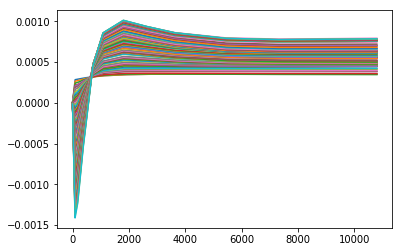

In [841]:
for i in range(inverse_r_interpolate.shape[0]):
    plt.plot(inverse_r_interpolate[i])

In [763]:
def PriceBond(params, r0, forDate, coupons_date, couponRate, num_coupons, N, faceValue=face):
    TimetoMaturity = np.apply_along_axis(lambda x: int((x - forDate)/ np.timedelta64(1,'D')), 1, coupons_date)
    res = np.zeros((N, TimetoMaturity[-1]))
    discount_factor = np.zeros((N, TimetoMaturity[-1]))
    for i in tqdm(range(N)):
        r, t = VasicekPath(TimetoMaturity[-1], params, r0)        
        B = np.zeros(r.shape)
#         r[TimetoMaturity-1] += np.log(num_coupons) # номинал дисконтируется по полной ставке
        
        #считаем значение показателя дисконтирования
        #d = np.cumproduct((1+np.exp(r))[::-1])[::-1]
        discount_factor[i] = 1 / np.exp(np.cumsum(-np.exp(r[::-1])))[::-1]
        
        #для каждого купона считаем его динамику цены (делим значение купона на показатель дисконтирования)
        for j in TimetoMaturity:            
            V = faceValue*couponRate if j != len(B) else faceValue*(1+couponRate)            
            B[:j] = V / discount_factor[i][:j]     
            res[i] += B
            
    return res, r, B, TimetoMaturity, discount_factor

In [842]:
inverse_r_interpolate.shape

(100, 10799)

In [843]:
caa = bond_result['coupons_date'][bond_result['coupons_date'] > tradeDate1].reshape(-1,1)
DaysToMaturity = np.apply_along_axis(lambda x: int((x - tradeDate1)/np.timedelta64(1,'D')), 1, caa)
DaysToMaturity

array([138, 320, 502, 684, 866])

In [844]:
TimeToMaturity

array([138, 320, 502, 684, 866])

In [845]:
inverse_r_interpolate.shape

(100, 10799)

In [903]:
couponRate[1]

0.038

In [916]:
N=100
faceValue = 1
num_coupons = 2
couponRate = bond_result['coupons_rate'][bond_result['coupons_date'] > tradeDate1]

TimeToMaturity = np.apply_along_axis(lambda x: int((x - tradeDate1)/np.timedelta64(1,'D')), 1, caa)
B = np.zeros((N, TimeToMaturity[-1]))
for i in range(N):    
    #для каждого купона считаем его динамику цены (делим значение купона на показатель дисконтирования)
    discount_factor = np.exp(-inverse_r_interpolate[i][np.arange(TimeToMaturity[-1])]*np.arange(TimeToMaturity[-1]))[::-1]
    for j,_ in enumerate(TimeToMaturity):        
        V = faceValue*couponRate[j]/num_coupons if j != len(TimeToMaturity)-1 else faceValue*(1+couponRate[j]/num_coupons)  
        b = (V / discount_factor)[:TimeToMaturity[j]]  
        B[i][:TimeToMaturity[j]] += b

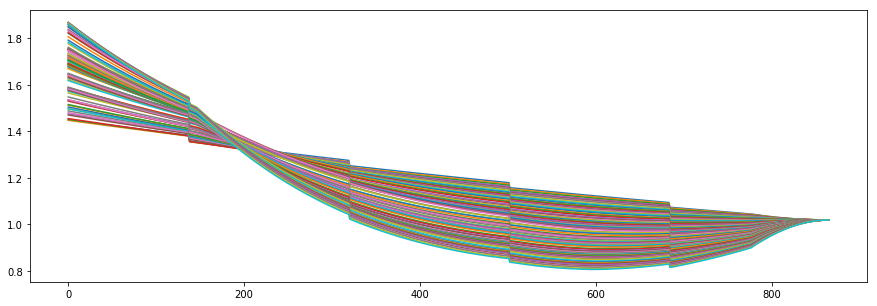

In [920]:
plt.figure(figsize=(15,5))
for i in range(B.shape[0]):
    plt.plot(B[i])

In [918]:
B[i][-1]

1.019